#### Code to train classification models
**TODO**:
- verif dist fts
- GroupKFold ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

## Imports

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [4]:
import os
import gc
import re
import glob
import json
import cudf
import lofo
import torch
import pickle
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from pandarallel import pandarallel
from numerize.numerize import numerize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from cuml.feature_extraction.text import TfidfVectorizer

pandarallel.initialize(progress_bar=False, use_memory_fs=False)
pd.options.display.max_columns = 500

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
from params import *

from data.features import *
from data.preparation import *
from data.post_processing import *

from utils.logger import prepare_log_folder, create_logger, save_config
from utils.metrics import *

from model_zoo.xgb import objective_xgb, lofo_xgb
from model_zoo.catboost import objective_catboost
from training.main_boosting import k_fold
from utils.plot import *

from matching import get_CV

### Params

## Model


In [6]:
df = cudf.read_csv(DATA_PATH + "train.csv")[["id", "point_of_interest"]]

In [7]:
path = '../output/folds_5.csv'
if os.path.exists(path):
    df_split = cudf.read_csv(path)
else:
    from sklearn.model_selection import StratifiedGroupKFold

    gkf = GroupKFold(n_splits=5)
    splits = list(gkf.split(df["id"].to_pandas(), groups=df['point_of_interest'].to_pandas()))


    df_split = df[["id", "point_of_interest"]].copy()
    df_split['fold'] = -1

    for i, (_, val_idx) in enumerate(splits):
        df_split.loc[val_idx, 'fold'] = i

    df_split.to_csv(path, index=False)

In [8]:
df_p = cudf.read_csv(OUT_PATH + "features_train_1.csv")
FEATURES = list(df_p.columns[2:])

In [9]:
df_p = df_p.merge(df_split, left_on="id_1", right_on="id", how="left")
df_p = df_p.merge(df_split, left_on="id_2", right_on="id", how="left", suffixes=('_1', '_2'))

In [10]:
# df_p = df_p.merge(df, left_on="id_1", right_on="id", how="left")
# df_p = df_p.merge(df, left_on="id_2", right_on="id", how="left", suffixes=('_1', '_2'))

In [11]:
df_p['match'] = (df_p['point_of_interest_1'] == df_p['point_of_interest_2']).astype(int)

In [12]:
df_p = df_p.sort_values(['id_1', 'id_2']).reset_index(drop=True)

In [13]:
OPTIMIZE = False
TRAIN = False
DEBUG = True
LOFO = False

OPT_FOLD = 2

### Param tweaking

In [14]:
PARAMS = {
    "xgb":
        {
            'max_depth': 10,
            'min_child_weight': 1,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            "colsample_bytree": 0.95,
            "subsample": 0.75,
#             'max_depth': 14, 
#             'gamma': 0.02, 
#             'min_child_weight': 9, 
#             'colsample_bytree': 0.864,
#             'subsample': 0.614,
#             'reg_alpha': 0.198,
#             'reg_lambda': 0.27,
        },
    "catboost":
        {
            'depth': 12,
#             'reg_lambda': 0.1,
#             "model_size_reg": 0.5,
#             "border_count": 256,
        },
    "lgbm": {
        'num_leaves': 500,
#         "max_depth" : 14,
        "min_child_weight": 1,
        "subsample": 0.75,
        "colsample_bytree": 0.95,
        "reg_alpha": 0.1,
        "reg_lambda" : 0.1,
    }
}

OBJECTIVES = {
    "xgb": objective_xgb,
    "catboost" : objective_catboost,
#     "lgbm": objective_lgbm,
}

In [15]:
NAME = "lgbm"  # "catboost", "xgb", "lgbm"
params = PARAMS[NAME]

In [16]:
if OPTIMIZE:
    df_train_opt = df_p[(df_p['fold_1'] != OPT_FOLD) & (df_p['fold_2'] != OPT_FOLD)].reset_index(drop=True)
    df_val_opt = df_p[
        (df_p['fold_1'] == OPT_FOLD) | (df_p['fold_2'] == OPT_FOLD)
    ].reset_index(drop=True)

    objective = OBJ_FCTS[NAME]
    objective = lambda x: objective(x, df_train_opt, df_val_opt, FEATURES, "match")

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    print("Final params :\n", study.best_params)

### Config

In [17]:
class Config:
    n_folds = 5

    features = FEATURES
#     cat_features = [ft for ft in FEATURES if "nan" in ft or "same" in ft]
    cat_features = ['country', 'cat2a', 'cat2b']

    target = "match"
    model = NAME
    params = params
    selected_folds = [0, 1, 2, 3, 4]

In [18]:
if len(Config.cat_features):
    df_p[Config.cat_features] = df_p[Config.cat_features].astype(int)

### LoFo

In [19]:
if LOFO:
    imp_df = lofo_xgb(
        df_p.sample(1000000).reset_index(drop=True),
        Config,
        folds=[0], #, 1, 2, 3, 4],  # [OPT_FOLD],
        auto_group_threshold=0.95
    )

    lofo.plot_importance(imp_df)
    plt.savefig(OUT_PATH + f"lofo_imp_{N_NEIGHBORS}.png", facecolor='white', transparent=False)
    imp_df.to_csv(OUT_PATH + f"lofo_imp_{N_NEIGHBORS}.csv", index=False)

# else:
#     if os.path.exists(OUT_PATH + f"lofo_imp_{N_NEIGHBORS}.csv"):
#         imp_df = pd.read_csv(OUT_PATH + f"lofo_imp_{N_NEIGHBORS}.csv")

In [20]:
# fts = []
# for ft in imp_df[imp_df['importance_mean'] > 0]['feature'].values.tolist():
#     fts += ft.split(' & ')

# Config.features = fts

# # Config.features = FEATURES

### Training

In [21]:
# df_p = df_p.sample(len(df_p) // 10).reset_index(drop=True)
df_p = df_p.to_pandas()
df_p = reduce_mem_usage(df_p)

Memory usage after optimization is: 3436.85 MB
Decreased by 73.7%


In [22]:
%%time

if TRAIN:
    log_folder = None
    if not DEBUG:
        log_folder = prepare_log_folder(LOG_PATH + "lvl_1/")
        print(f'Logging results to {log_folder}')
        save_config(Config, log_folder + 'config')
        create_logger(directory=log_folder, name="logs.txt")

    pred_oof, models, ft_imp = k_fold(df_p, Config, log_folder=log_folder)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


### Retrieve

In [23]:
EXP_FOLDER = LOG_PATH + "lvl_1/" + "2022-06-26/6/"  # xgboost gkf


In [24]:
if not TRAIN:
    pred_oof = np.load(EXP_FOLDER + "pred_oof.npy")
    ft_imp = pd.read_csv(EXP_FOLDER + "ft_imp.csv").set_index('Unnamed: 0')

## Results

In [25]:
import warnings
warnings.simplefilter("ignore")

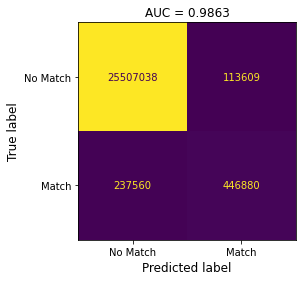

In [26]:
y = df_p[Config.target].values if isinstance(df_p, pd.DataFrame) else df_p[Config.target].get()

plot_confusion_matrix(
    pred_oof > 0.5,
    y,
    display_labels=['No Match', 'Match'],
#     normalize="pred"
)

plt.title(f"AUC = {roc_auc_score(y, pred_oof) :.4f}")
plt.show()

In [27]:
df = df.to_pandas().reset_index()
df = df.sort_values(by=["point_of_interest", "id"]).reset_index(drop=True)

id_all = np.array(df["id"])
poi_all = np.array(df["point_of_interest"])
poi0 = poi_all[0]
id0 = id_all[0]

di_poi = {}
for i in range(1, df.shape[0]):
    if poi_all[i] == poi0:
        id0 = str(id0) + " " + str(id_all[i])
    else:
        di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
        poi0 = poi_all[i]
        id0 = id_all[i]

di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
df["m_true"] = df["point_of_interest"].map(di_poi)

df = df.sort_values(by="index").reset_index(
    drop=True
)  # sort back to original order
df.drop("index", axis=1, inplace=True)

In [28]:
_ = get_CV(None, None, y, pred_oof, df.copy(), df_p.copy()) # get CV

- Highest reachable IoU : 0.9874
- Threshold 0.4 : CV 0.8393
- Threshold 0.45 : CV 0.8453
- Threshold 0.5 : CV 0.8491
- Threshold 0.55 : CV 0.8514
- Threshold 0.6 : CV 0.8518
- Threshold 0.65 : CV 0.8510

-> Best Threshold 0.6 : CV 0.8518


### Check several cut levels

In [29]:
df_p[Config.target] = y

for thresh in [.0025, .005, .0075, .01]:
    print(f'\nRemoving pairs with p < {thresh} : ')
    df_cut = df_p.loc[pred_oof > thresh].reset_index()
    y_cut = df_cut[Config.target].values

    try:
        print(f"- Number of candidates : {numerize(len(y_cut))}")
    except NameError:
        print(f"- Number of candidates : {len(y_cut)}")
    print(f"- Proportion of positive candidates: {y_cut.mean() * 100:.2f}%")
    
    get_CV(None, None, y_cut, y_cut, df.copy(), df_cut.copy())


Removing pairs with p < 0.0025 : 
- Number of candidates : 5.63M
- Proportion of positive candidates: 12.02%
- Highest reachable IoU : 0.9871

Removing pairs with p < 0.005 : 
- Number of candidates : 4.23M
- Proportion of positive candidates: 15.87%
- Highest reachable IoU : 0.986

Removing pairs with p < 0.0075 : 
- Number of candidates : 3.56M
- Proportion of positive candidates: 18.74%
- Highest reachable IoU : 0.985

Removing pairs with p < 0.01 : 
- Number of candidates : 3.14M
- Proportion of positive candidates: 21.11%
- Highest reachable IoU : 0.9842


In [ ]:
THRESHOLD = 0.0075

df_p_r = df_p[pred_oof > THRESHOLD].reset_index(drop=True)

df_p_r.to_csv(OUT_PATH + "features_train_1_filtered.csv", index=False)

### Feature importance

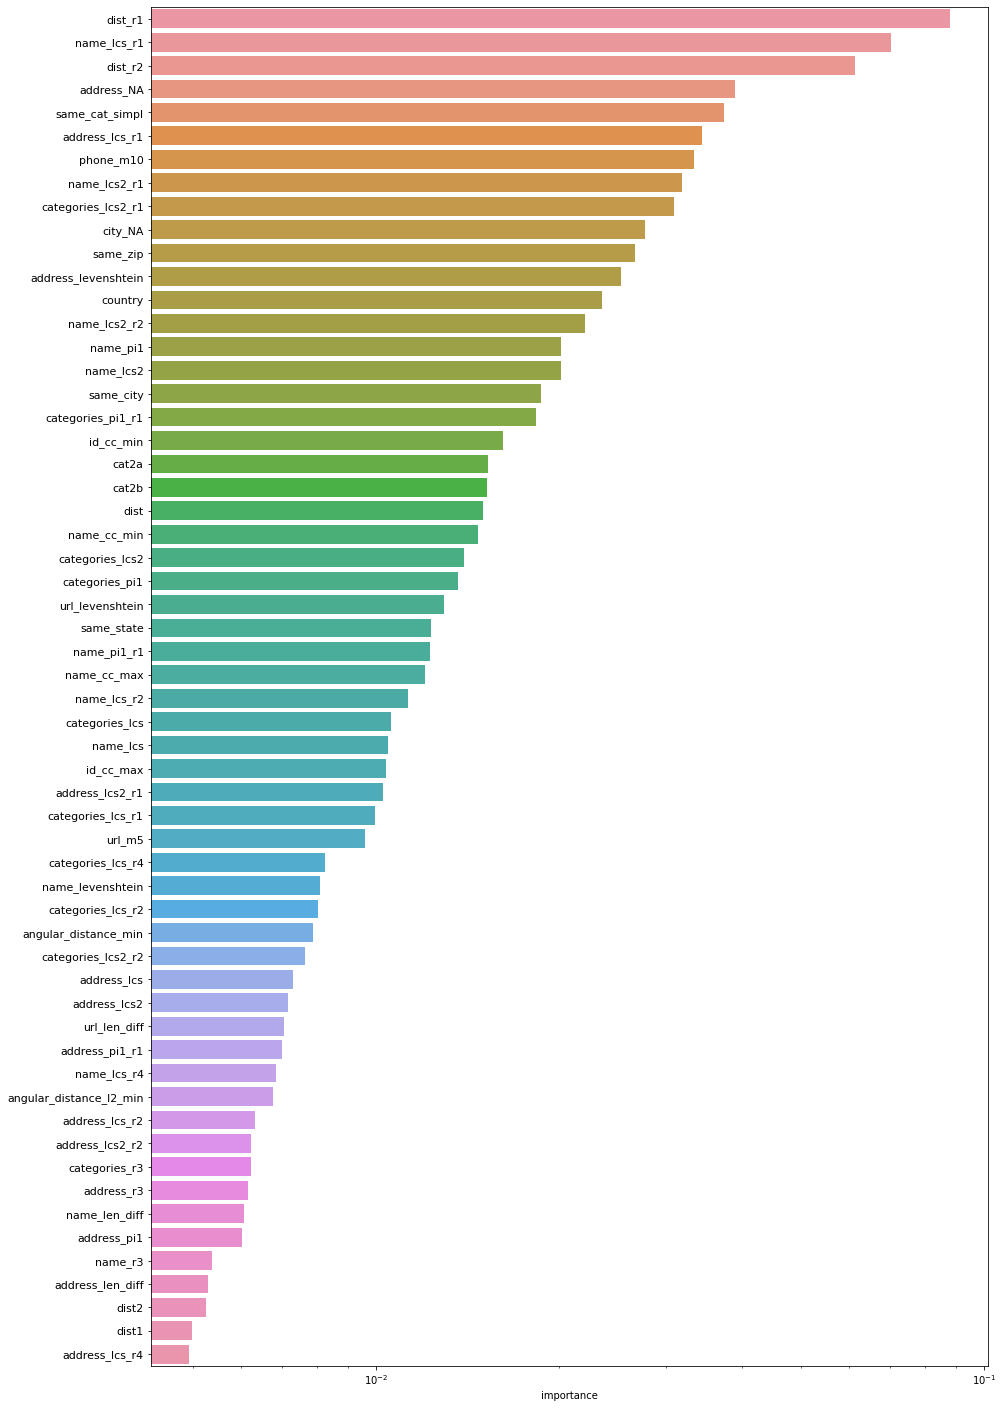

In [26]:
plot_importances(ft_imp)
plt.xscale('log')
plt.show()